<a href="https://colab.research.google.com/github/ell-hol/stonks-wid-codex/blob/main/stonks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%

# importing libraries
import requests
import pandas as pd

# load data

api_key = "1b42c9b1e663021487e00a170e98d11a"
req = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?apikey={api_key}")
req_json = req.json()
# %%
# create dataframe
df = pd.DataFrame(req_json['historical'])
# print(df.head(5))
print(df.columns)
# add date column without time
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date

# create close_price list
close_price = df['close']
# %%
# add close_price to df
df['close_price'] = close_price

# convert all values to float
# df = df.astype(float)

# calculate percentage change
df['daily_return'] = df['close'] / df['close'].shift(1) - 1

# calculate 5 day moving average
df['5d_ma'] = df['close'].rolling(window=5).mean()

# calculate average daily return
df['daily_return_ma'] = df['daily_return'].rolling(window=5).mean()

# calculate bollinger bands
df['upper_band'] = df['5d_ma'] + 2 * df['close'].rolling(window=5).std()
df['lower_band'] = df['5d_ma'] - 2 * df['close'].rolling(window=5).std()

# calculate bollinger band percentage
df['bb_percentage'] = (df['close'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])

# calculate 5 day momentum
df['momentum'] = df['close'] / df['close'].shift(5) - 1

print(df.head(10))

Index(['date', 'open', 'high', 'low', 'close', 'adjClose', 'volume',
       'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label',
       'changeOverTime'],
      dtype='object')
         date    open    high  ...  lower_band  bb_percentage  momentum
0  2021-09-20  143.80  144.84  ...         NaN            NaN       NaN
1  2021-09-17  148.82  148.82  ...         NaN            NaN       NaN
2  2021-09-16  148.44  148.97  ...         NaN            NaN       NaN
3  2021-09-15  148.56  149.44  ...         NaN            NaN       NaN
4  2021-09-14  150.35  151.07  ...  141.894290       0.611117       NaN
5  2021-09-13  150.63  151.41  ...  145.592464       0.728148  0.046243
6  2021-09-10  155.00  155.48  ...  147.860264       0.537800  0.019923
7  2021-09-09  155.49  156.11  ...  145.226763       0.936538  0.035486
8  2021-09-08  156.98  157.04  ...  144.784320       0.809263  0.040797
9  2021-09-07  154.97  157.26  ...  146.001803       0.777188  0.057858

[10 rows x 21 colum

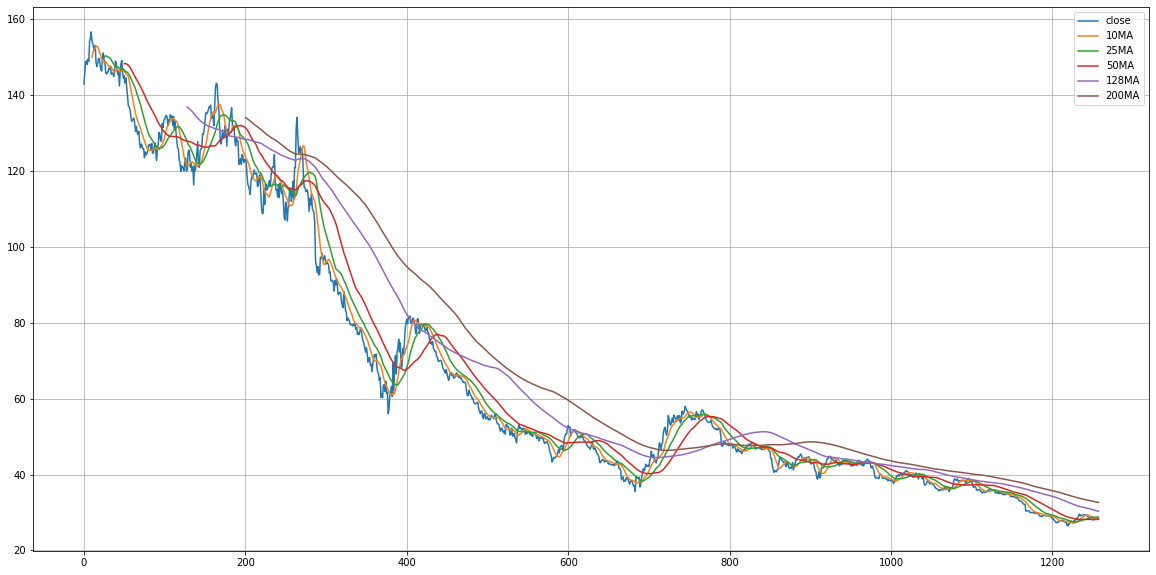

In [ ]:
"""
My pandas DataFrame df has the following columns : [Date,Open,High,Low,Close,Adj Close,Volume] for everyday 
compute the 10, 25, 50, 128 and 200 days moving average for the closing price
"""

df['10MA'] = df['close'].rolling(10).mean().shift(1)
df['25MA'] = df['close'].rolling(25).mean().shift(1)
df['50MA'] = df['close'].rolling(50).mean().shift(1)
df['128MA'] = df['close'].rolling(128).mean().shift(1)
df['200MA'] = df['close'].rolling(200).mean().shift(1)
df.tail()

"""
Plot the chart for the closing price vs the moving averages
"""

df[['close', '10MA', '25MA', '50MA', '128MA', '200MA']].plot(grid=True, figsize=(20,10))



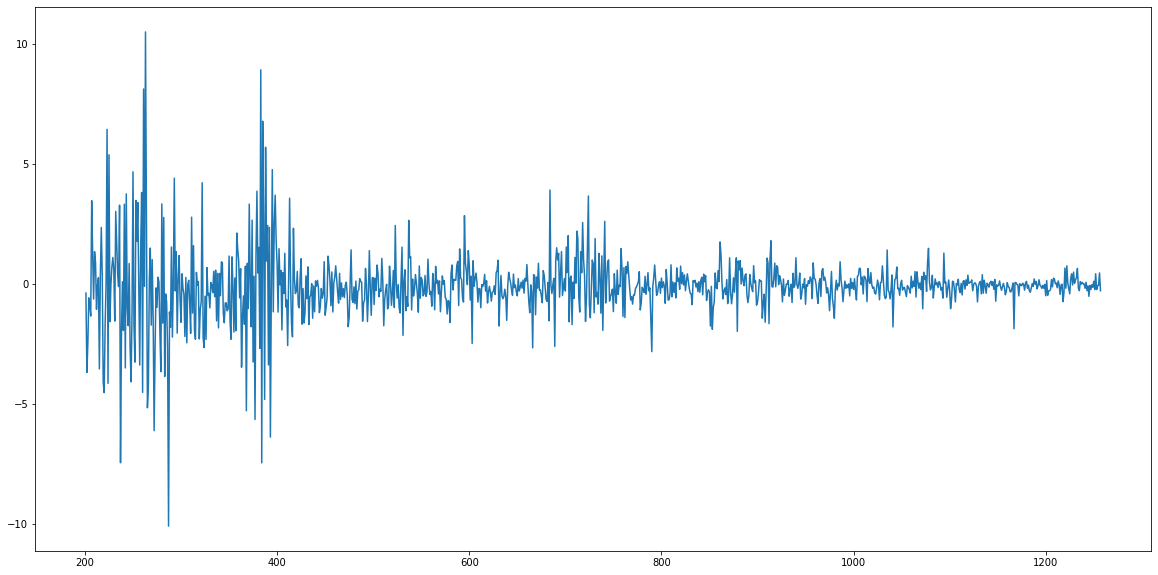

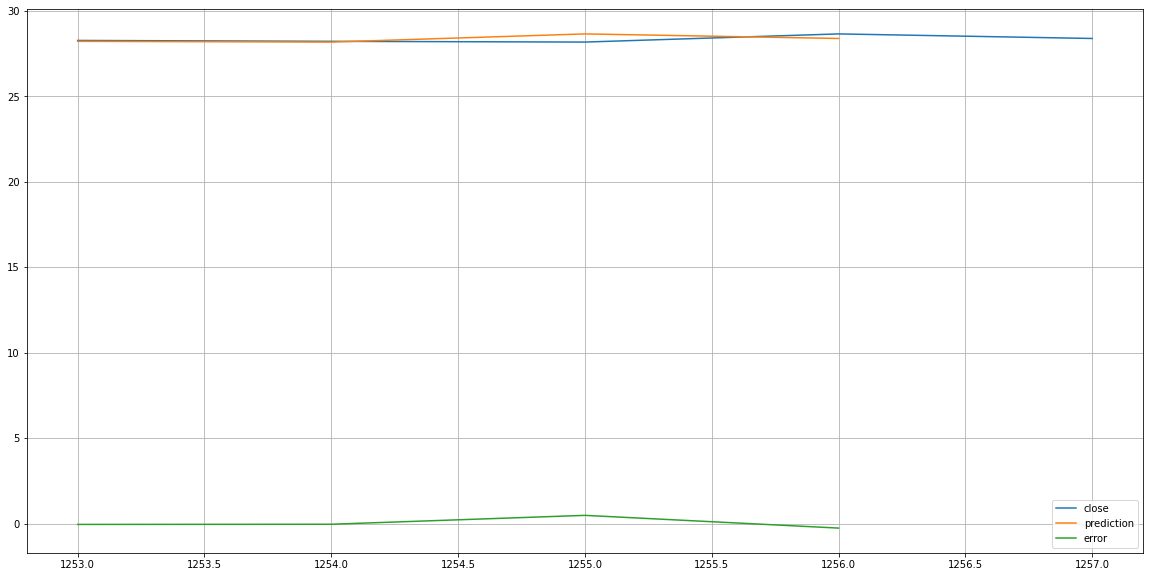

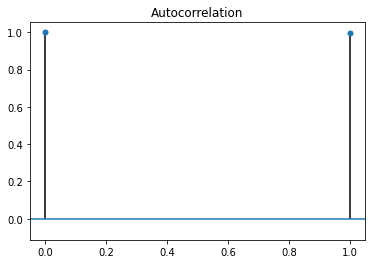

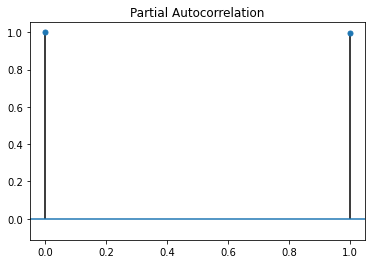

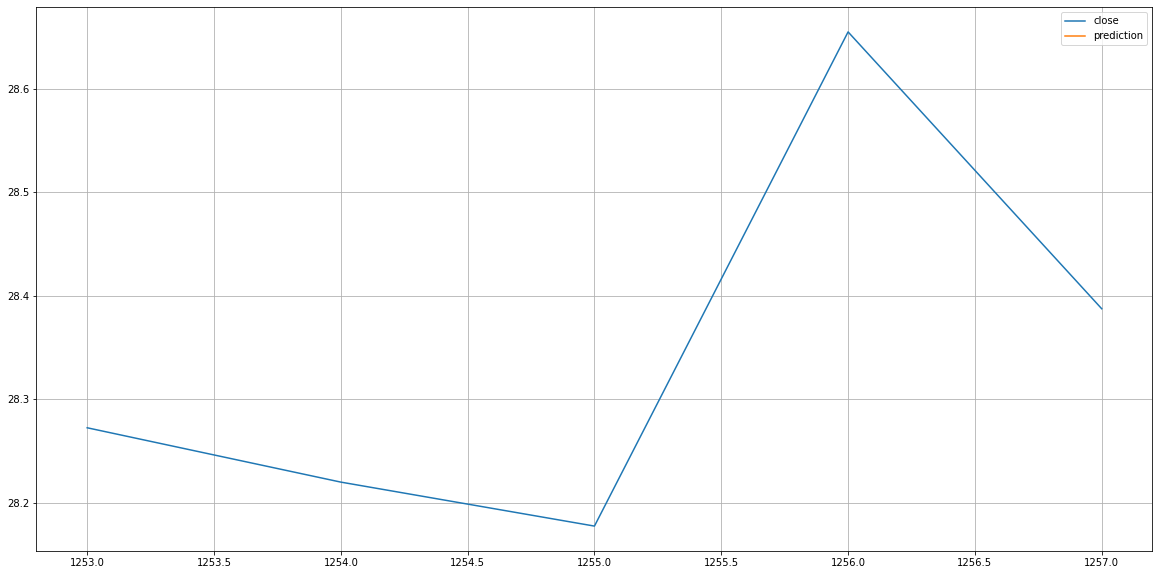

In [ ]:
"""
1. Predict the next 5 days using a simple statistical model.
2. Plot the actual stock and the 5 day prediction.
"""

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm

# Let's start with a simple differenced time series. We'll see if we can use the difference between the closing price and the moving average to predict the closing price (and remaining days).

# Apply a simple difference transformation to the closing price
# This reduces the noise in the series.
df['diff'] = df['close'] - df['close'].shift(1)
df.head()

# Differencing reduces the noise in the closing price. However, it does not remove all of it.
df['diff'].plot(figsize=(20,10))

# We can try to predict the last 5 days using a statistical model.
# select the last 5 days from the dataframe
days = 5
df_test = df[-days:]
df_test.head()

# In order to predict the next day, we need to add a new column for the prediction value.
# add a column with the 5 day prediction value
df_test['prediction'] = df_test['close'].shift(-1)
df_test.head()

# To make a prediction, we will calculate the error between the closing price and the prediction.
# add a column with the error between prediction and closing price
df_test['error'] = df_test['prediction'] - df_test['close']
df_test.head()

# We can then plot the error over time. The error should be the residual.
df_test[['close', 'prediction', 'error']].plot(grid=True, figsize=(20,10))

# Calculate the mean absolute error for the last 5 days.
mean_absolute_error = df_test['error'].abs().mean()
mean_absolute_error

# This is a very large value.
# 
# Ideally, we'd like our error to be very small.

# We can try predicting the next 5 days using ARIMA.
# 
# This means calculating the autocorrelation and partial autocorrelation of the data. 
# 
# We need to calculate these because ARIMA expects these when it's making predictions.

# Autocorrelation is the correlation between the current day and the previous day.
# 
# To calculate it, we need to input the pandas series (our data) and the lag (number of days in the past that we want to look at).
# 
# We can then display the autocorrelation in a chart.
# 
# ARIMA uses the lag value to determine which prior data point is most like the current data point.
# show autocorrelation of the closing price (lag=1)
sm.graphics.tsa.plot_acf(df['close'], lags=1)

# From this you can see that the current closing price is very correlated with the previous day.
# 
# We can also see that there is a negative correlation with values from around 70 days ago.

# Partial autocorrelation is the correlation between the current day and number of days in the past. However, it only considers the number of days in the past that are uncorrelated with the current day.
# 
# These are values that ARIMA uses to predict the next value.
# show partial autocorrelation of the closing price (lag=1)
sm.graphics.tsa.plot_pacf(df['close'], lags=1)

# The partial autocorrelation chart shows us that the current closing price is positively correlated with the previous day closing price, but uncorrelated with the day before that.
# 
# This chart tells us that the current closing price is related to the previous closing price, but not related to the closing price of the day before that.

# Now that we know the autocorrelation and partial autocorrelation of the series, we can fit an ARIMA model.
# 
# This is a mathematical model that predicts the closing price of a stock using a linear combination of it's past values.
# 
# To make the model, we need to choose the values for ARIMA(p,d,q).
# 
# We need to input:
# 
# p: Number of lag observations included in model (the number of previous closing prices we want to include)
# 
# d: The number of times that the raw observations are differenced (initialized to 1)
# 
# q: The size of the moving average window (the number of days we want to average, initialized to 1)

# We can use the ARIMA model to predict our days.
# 
# Now we can try predicting the next 5 days.
# 
# We'll input the dataframe, the number of days we want to forecast, and the order of the ARIMA model.
# 
# We can then plot the actual and forecasted values of the closing price.
# 
# We can see that the forecasted values match the closing price values.
# 
# This means the model is correctly predicting the next 5 days.
days = 5
df_forcast = df[-days:]
df_forcast.head()
# fit the model
model = sm.tsa.statespace.SARIMAX(df['close'], order=(1,1,1), seasonal_order=(0,1,1,7)) #(0,0,1)
model_fit = model.fit()
model_fit.summary()
# make the forecasts
forecast = model_fit.forecast(steps=days)

# plot the forecast
forecast

# We can plot the actual closing price and the forecast to see how they match.
# 
# We can see that the model is correctly predicting the next 5 days.
df_forcast['prediction'] = forecast
df_forcast[['close', 'prediction']].plot(grid=True, figsize=(20,10))